In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0005.nc')
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini_exact_gamma_delta_old'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
KRMAX = 40
zeta_r = np.arange(0.,1. + 1.0/KRMAX, 1.0/KRMAX)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(6, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

log_c_slide_init = np.log10(0.85)*np.ones((JMAX+1, IMAX+1))
data = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -10)
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)
log_n_glen_da_dummy2d_scalar = np.log10(3.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_q_geo": log_q_geo,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_n_glen_da_dummy2d_scalar": log_n_glen_da_dummy2d_scalar}
dict_prior_params_fields_vals = dict_og_params_fields_vals.copy()
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_q_geo": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_n_glen_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "zeta_r": zeta_r,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_n_glen_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_q_geo": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_n_glen_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": (vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": (vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_p_weert": 0.01,
                     "xx_q_weert": 0.01,
                     "xx_enh_fact_da_dummy2d_scalar": 0.01,
                     "xx_enh_intg_da_dummy2d_scalar": 0.01,
                     "xx_n_glen_da_dummy2d_scalar": 0.01}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_q_geo": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_n_glen_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 2.0e-4,
                     "xx_q_geo": 2.0e-4,
                     "xx_p_weert": 1.0,
                     "xx_q_weert": 1.0,
                     "xx_enh_fact_da_dummy2d_scalar": 1.0,
                     "xx_enh_intg_da_dummy2d_scalar": 1.0,
                     "xx_n_glen_da_dummy2d_scalar": 1.0}
                     
list_fields_to_ignore = None

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

Pearson correlation y-direction 40 kms:  0.8436473496588696
Pearson correlation y-direction 80 kms:  0.6222542093238166
Pearson correlation y-direction 120 kms:  0.4130231008526096
Pearson correlation y-direction 160 kms:  0.2706446803076103
Pearson correlation y-direction 200 kms:  0.16275193159859017
Pearson correlation y-direction 240 kms:  0.13284588506596884
Pearson correlation y-direction 280 kms:  0.10724781262935928
Pearson correlation y-direction 320 kms:  0.06087263760294269
Pearson correlation y-direction 360 kms:  0.060524194882807955
Pearson correlation y-direction 400 kms:  0.05998737802000483
Pearson correlation x-direction 40 kms:  0.7922417797753325
Pearson correlation x-direction 80 kms:  0.5721858409702879
Pearson correlation x-direction 120 kms:  0.36837698062247787
Pearson correlation x-direction 160 kms:  0.22765359560297835
Pearson correlation x-direction 200 kms:  0.16166268147948698
Pearson correlation x-direction 240 kms:  0.11224244681138291
Pearson correlati

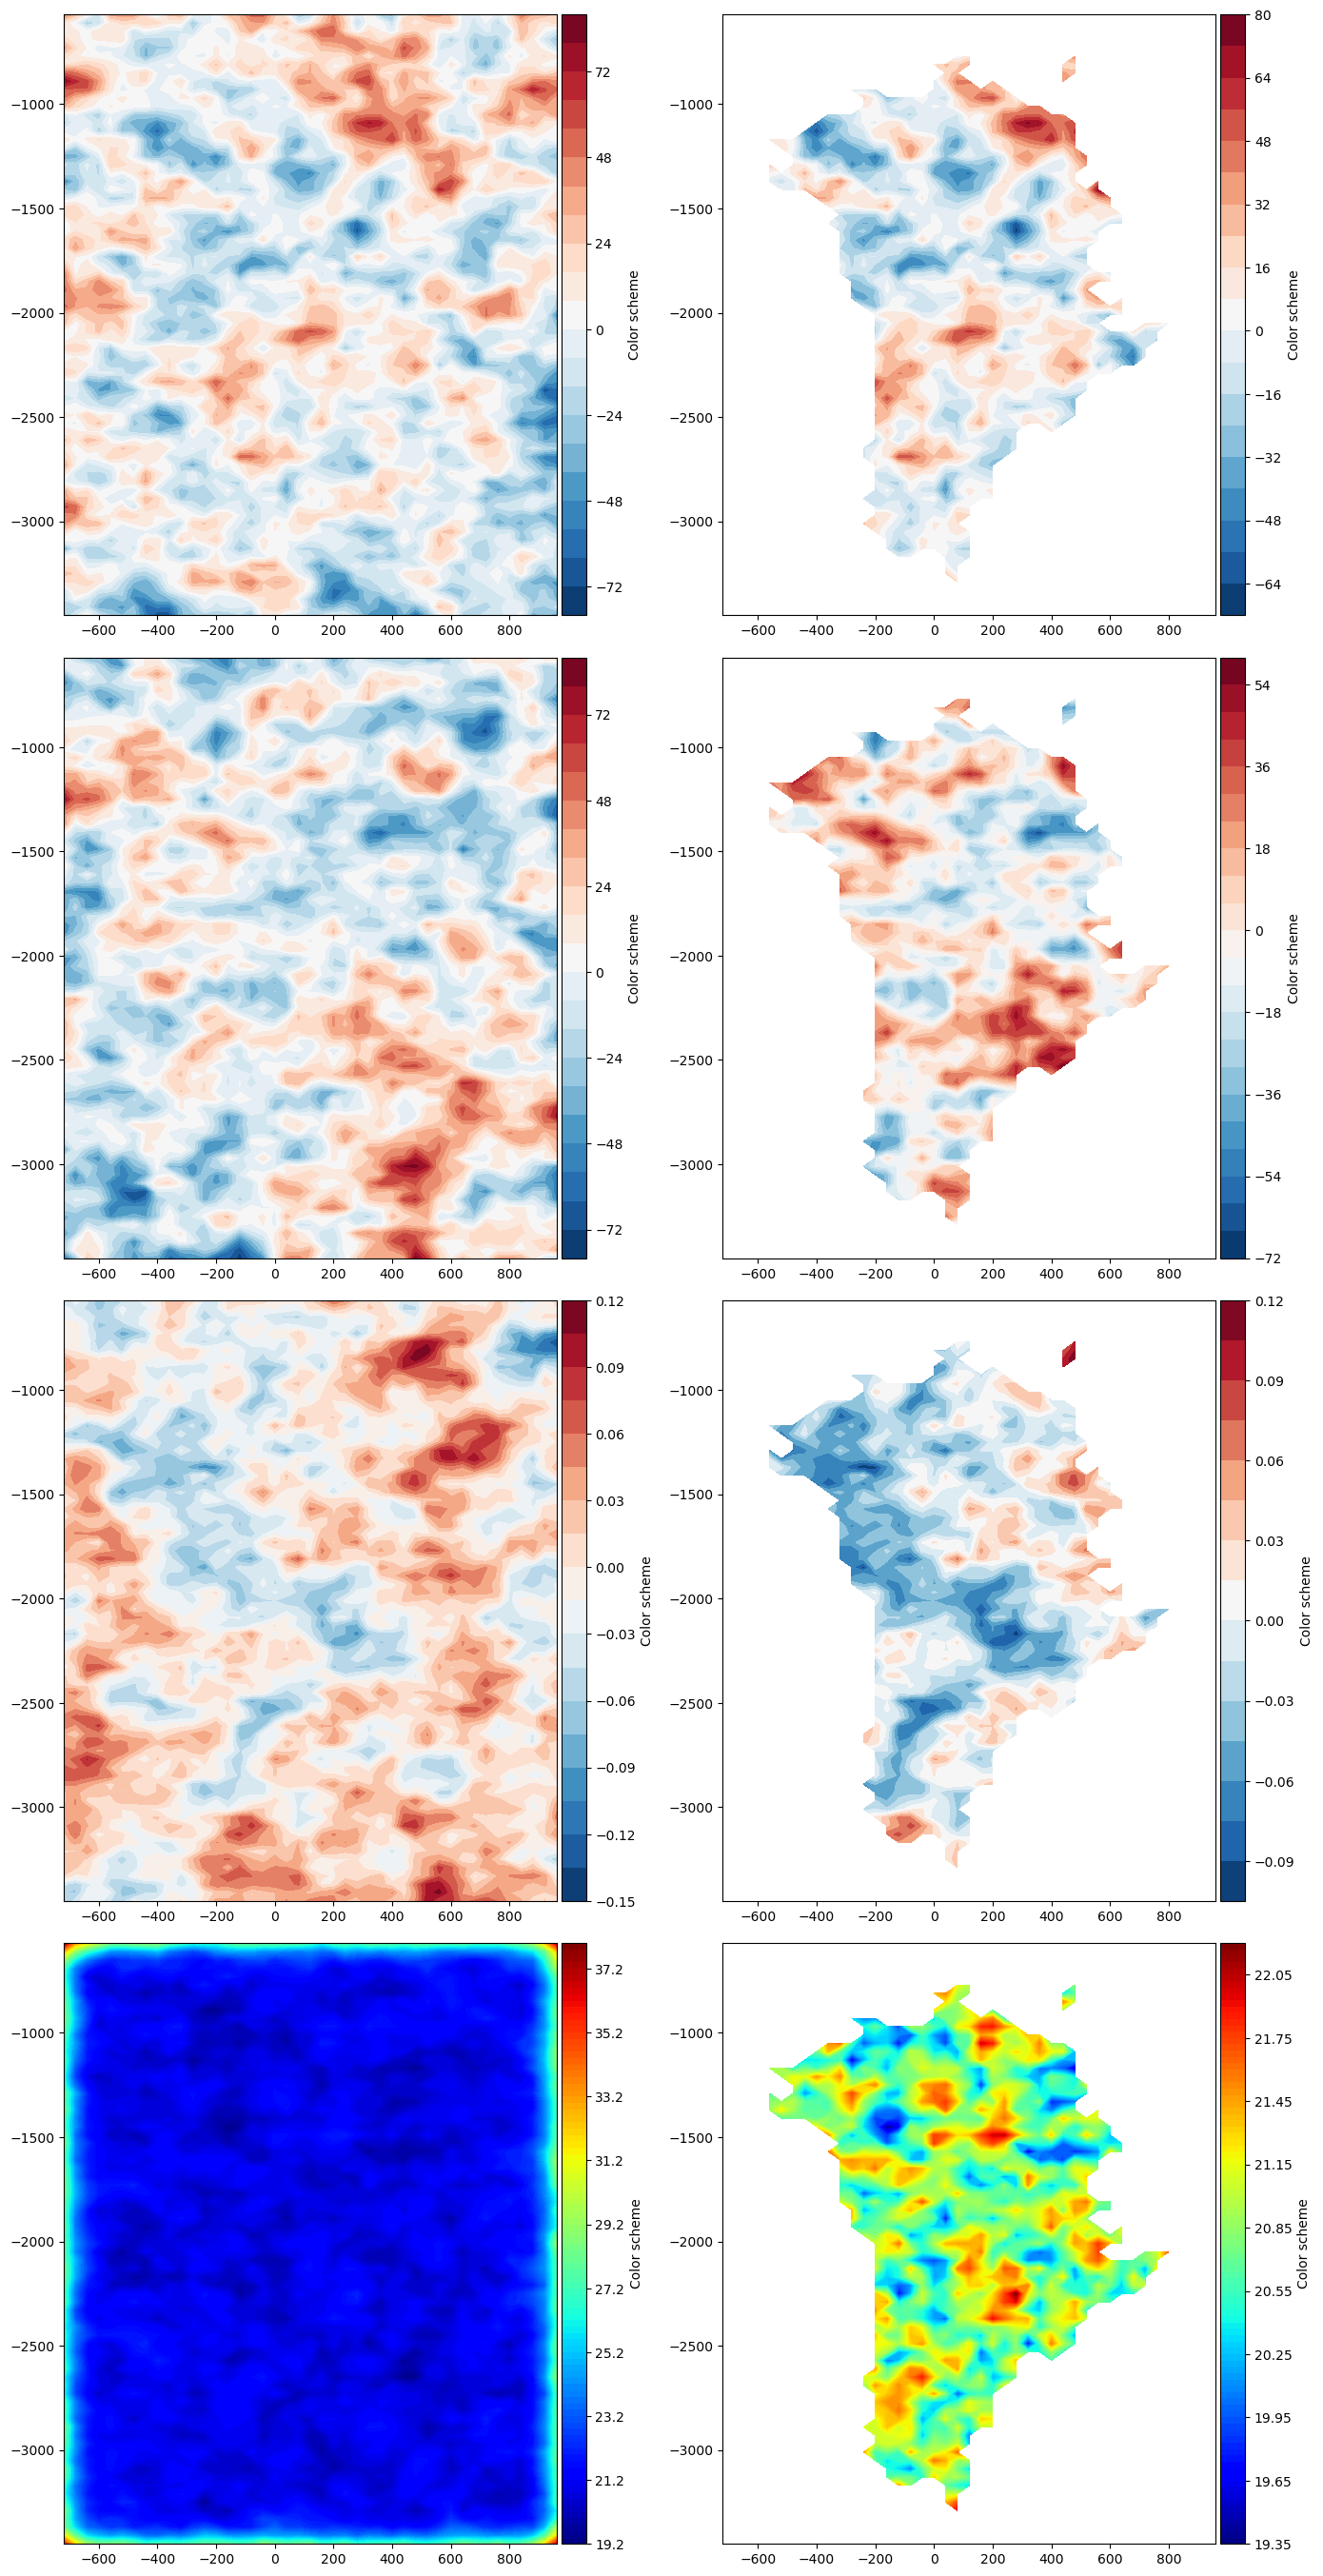

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old", 1000, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 1000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

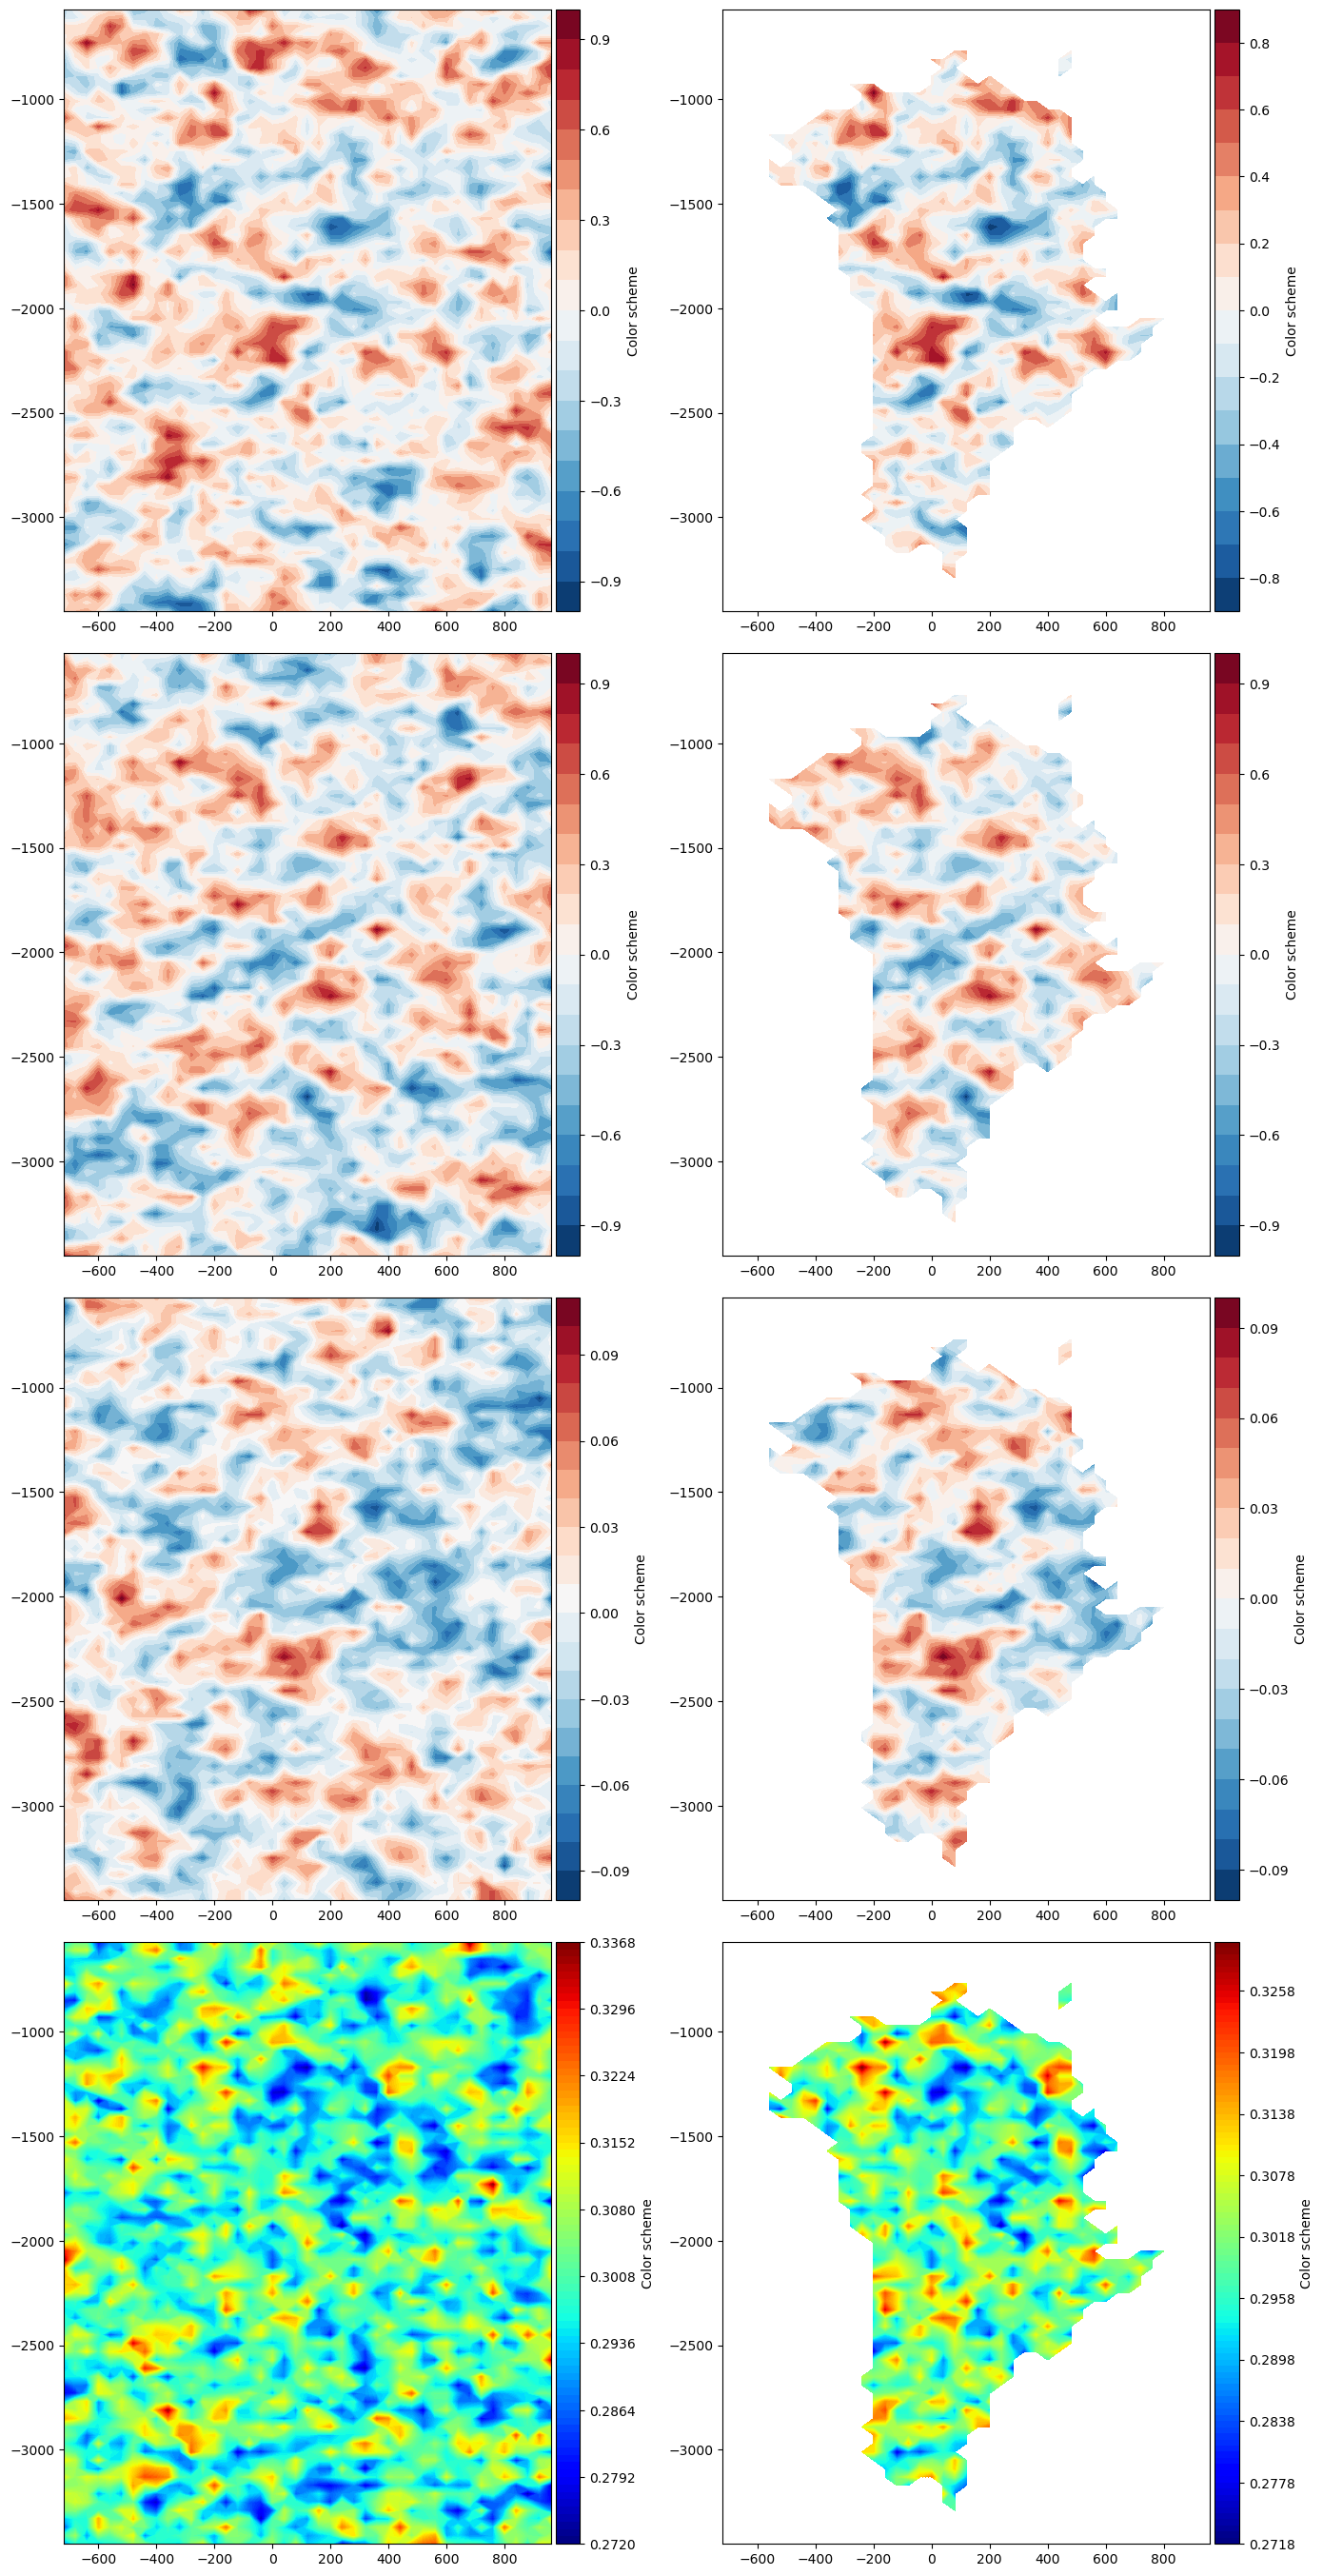

In [5]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [6]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(18002613.46894014, 18002613.468936745)

In [7]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(18002613.46894014, 18002613.468936745)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(500393.4509657616, 500393.45096575504)

In [9]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(6059.836076610684, 6059.836076610686)

In [10]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(583.575957977863, 6059.836076610686)

In [11]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3DR":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KRMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(583.575957977863, 583.575957977863)

In [12]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(500393.4509657616, 506453.2870423723, 506453.28704237234)

In [13]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old", None, ds_prior_X)

# ds = DA.gradient_descent(2, init_alpha = 1.0, min_alpha_tol = 1.e-10)

# H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
# H_data = H_data_40["H"].data
# mask = 1.0*(H_data > 0)
# mask[mask == 0] = np.nan

# n_rows, n_cols = 2, 2
# aspect_ratio = len(xModel40)/len(yModel40)
# subplot_width = 4
# subplot_height = subplot_width / aspect_ratio
# plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
# fig, ax = plt.subplots(n_rows, n_cols)

# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data*mask,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 1])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data*mask,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
# plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 650822.595775314, fc_data = 650822.595775314, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 166153.67385728602, norm_r_hat: 77978.74594926232
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 167158.22913952303, fc_data = 167152.88234933303, fc_reg = 5.346790189991166
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 32569.594451167515, norm_r_hat: 13393.573554528111
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  179.99999879258172
Step size alpha = 1.0
------------------

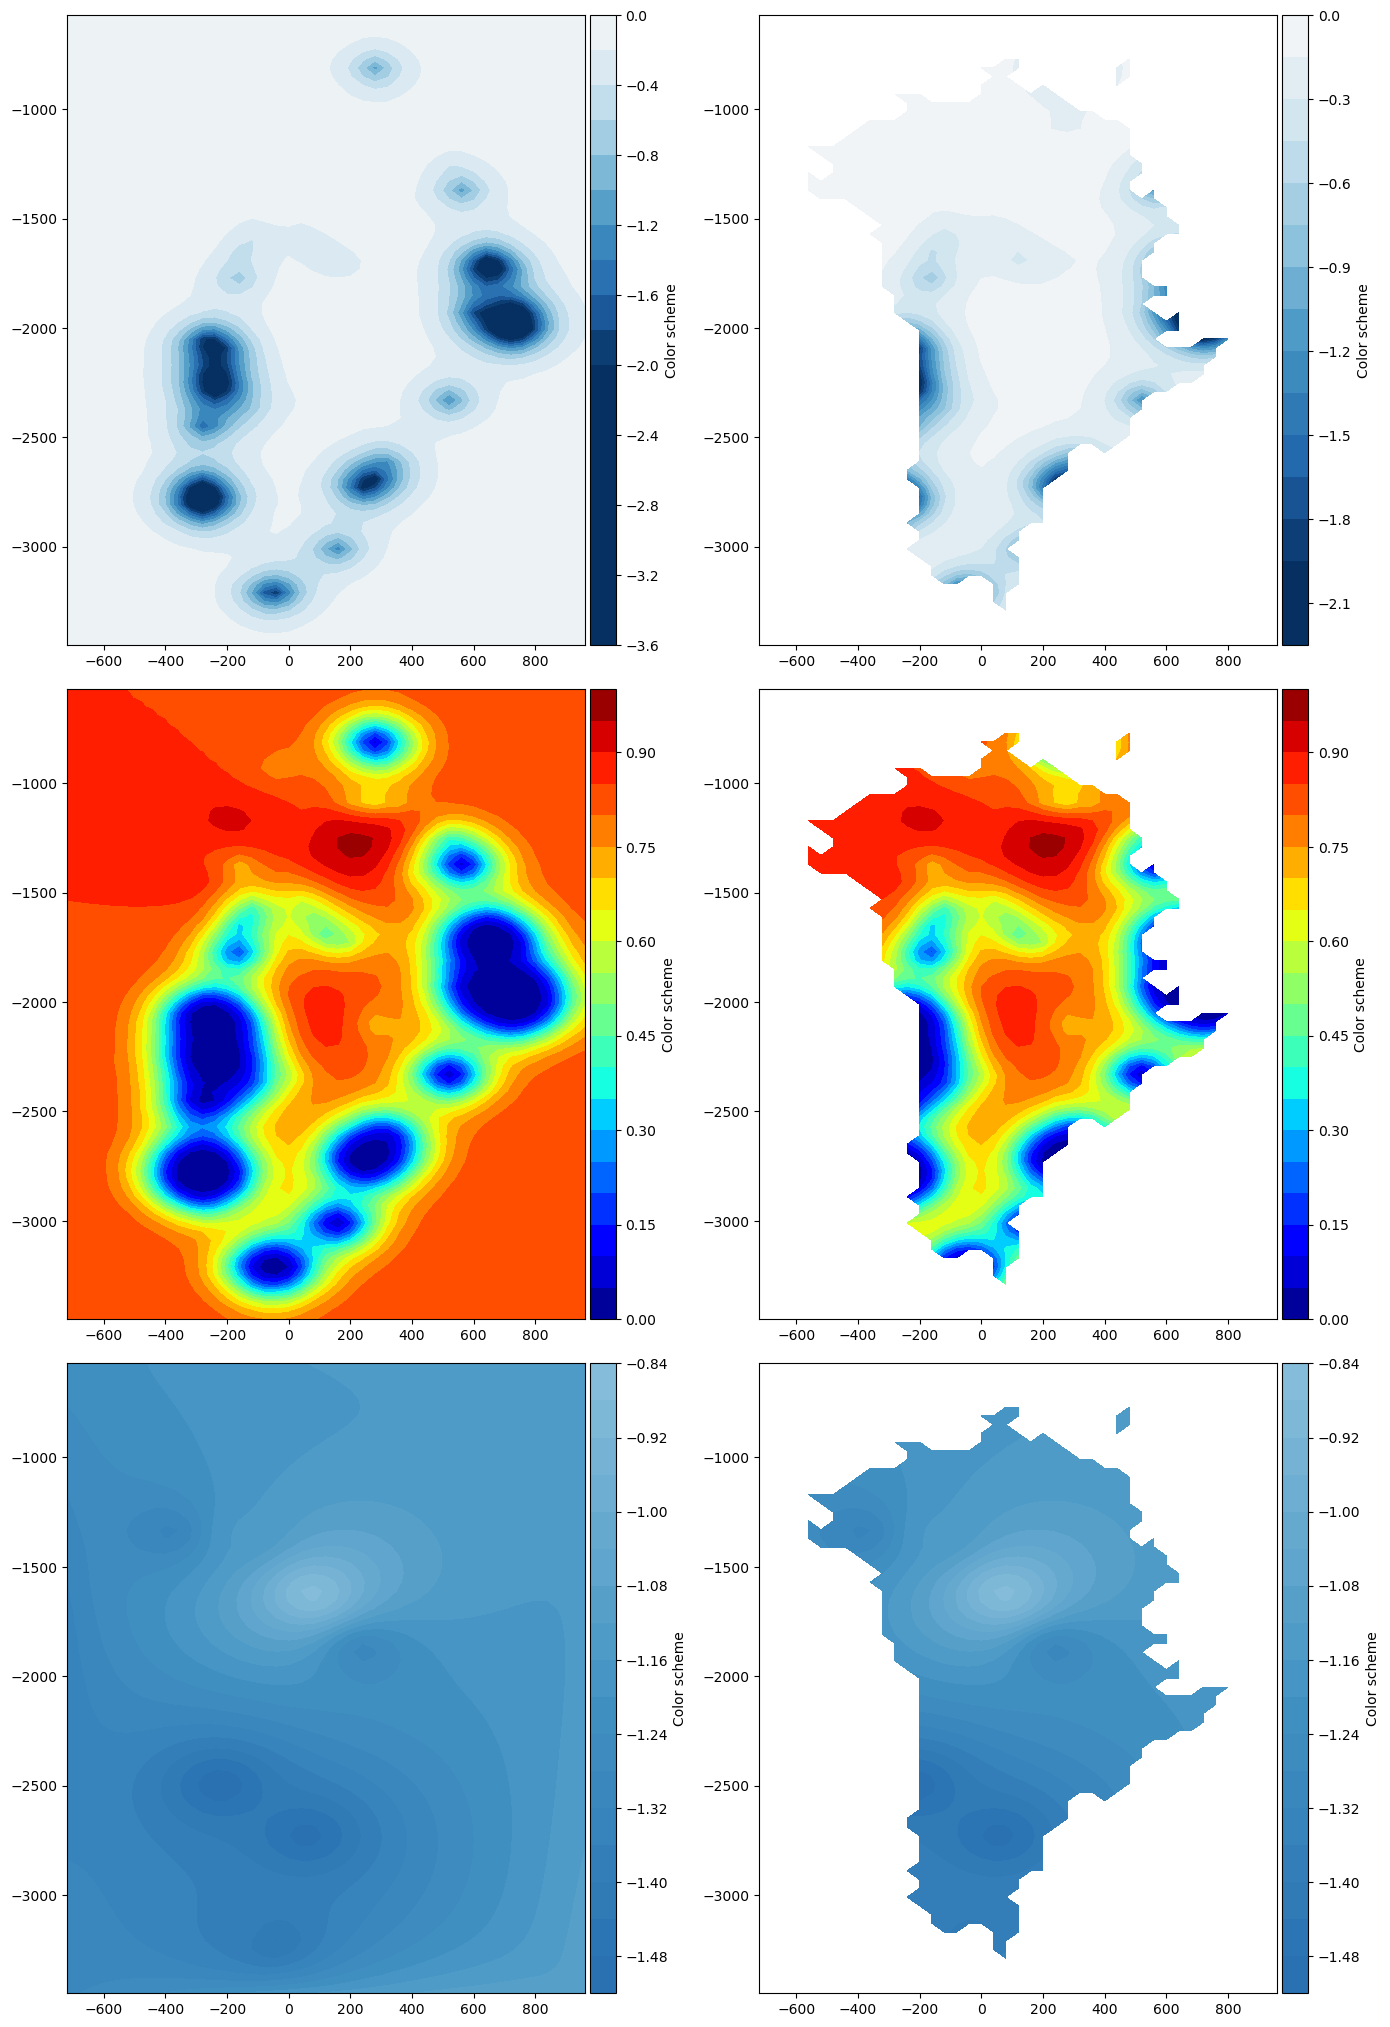

In [14]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old", None, ds_prior_X)

ds = DA.inexact_gn_hessian_cg(MAX_ITERS = 5, min_alpha_cg_tol = 1.e-20, init_alpha_gd = 1.e-6, min_alpha_gd_tol = 1.e-20)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 3, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 1])
plt.tight_layout()

In [15]:
ds

<xarray.Dataset> Size: 51kB
Dimensions:                        (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                              (y) float64 584B -3.45e+03 ... -570.0
  * x                              (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_init                (y, x) float64 25kB -0.0706 ... -0.07059
    xx_q_geo                       (y, x) float64 25kB -1.286 -1.28 ... -1.146
    xx_p_weert                     (scalar) float64 8B 0.521
    xx_q_weert                     (scalar) float64 8B 0.2576
    xx_enh_fact_da_dummy2d_scalar  (scalar) float64 8B 0.03115
    xx_enh_intg_da_dummy2d_scalar  (scalar) float64 8B -0.05504
    xx_n_glen_da_dummy2d_scalar    (scalar) float64 8B 0.7777

In [16]:
temp = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini_exact_gamma_delta_old/src/subroutines/tapenade/ad_io/ad_output_adj.nc")
temp["xx_n_glen_da_dummy2d_scalar"].data[0], ds["xx_n_glen_da_dummy2d_scalar"].data[0]

(0.604066130384658, 0.7777279002078084)

In [17]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [18]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.78376471299184e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.5709464897237824e-15
eig (symmetrized) vs eigh:  1.1998302003140666e-15
First 10 eigenvalues: [2.15914744 1.78552189 1.45389321 1.44871638 1.2979589  1.04292829
 0.96024111 0.90994356 0.74855257 0.6356173 ]
Relative symmetry error of T:  4.150893834005906e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.2127381628089311e-15
eig (symmetrized) vs eigh:  1.0831982535939764e-15
First 13 eigenvalues: [2.19953912 1.79260447 1.51665784 1.49719546 1.34873674 1.10373039
 1.01800374 0.95069816 0.90539226 0.80275818 0.72681302 0.60115328
 0.53558294]
Double precise total time: 320.2964 seconds


/home/shreyas/pySICOPOLIS/src/pySICOPOLIS/optim/optim.py:1633: RuntimeWarning: revd: Check the comments at the start of this function to see what might be missing from the single pass, it's essentially remark 5.4 of Halko, Martinsson, Tropp's paper.
  raise ValueError("revd: str_pass can olny be double_precise or single_approx.")


Condition number of Q.T @ Omega:  2.277246644817188
Minimum singular value of Q.T @ Omega:  4.929917331184652
Condition number of Q.T @ Omega explicitly computed:  2.2772466448171884
Relative symmetry error of T:  1.8686357943104183e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.2606989907476958e-15
eig (symmetrized) vs eigh:  1.7318073399461509e-15
First 10 eigenvalues: [1.80884466 1.35661888 1.13266958 0.8903223  0.80120532 0.74835951
 0.64401666 0.55713888 0.482202   0.38690027]
Condition number of Q.T @ Omega:  2.6341435242001476
Minimum singular value of Q.T @ Omega:  4.368675476617457
Condition number of Q.T @ Omega explicitly computed:  2.6341435242001494
Relative symmetry error of T:  1.8565445081847476e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.9296020892319367e-15
eig (symm

(array([2.19953912, 1.79260447, 1.51665784, 1.49719546, 1.34873674,
        1.10373039, 1.01800374, 0.95069816, 0.90539226, 0.80275818,
        0.72681302, 0.60115328, 0.53558294]),
 array([1.84426582, 1.40200272, 1.15850283, 0.97644412, 0.8574117 ,
        0.83319223, 0.76402028, 0.64657433, 0.49586113, 0.40094581,
        0.36671233, 0.34353807, 0.31628158]))

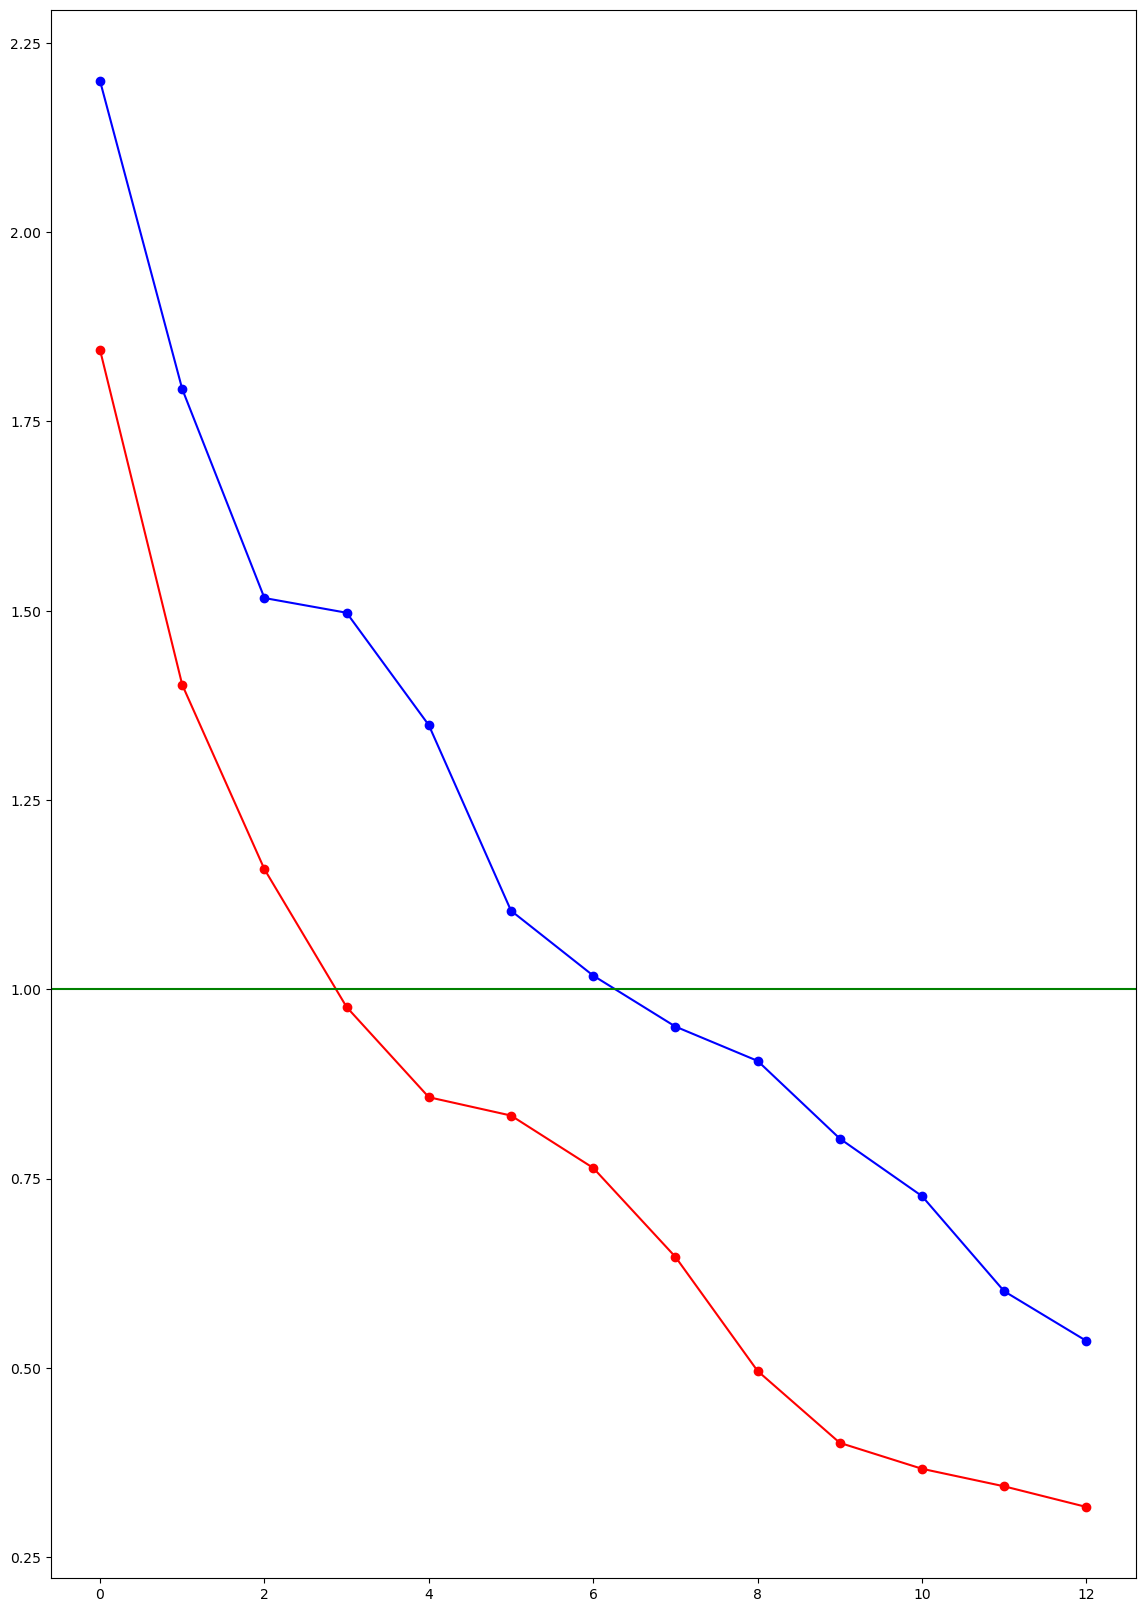

In [19]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.5716341042730314e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.599759612795638e-15
eig (symmetrized) vs eigh:  1.074887215919045e-15
First 10 eigenvalues: [2.13309947 1.85292967 1.42809666 1.39470241 1.09704277 1.04901163
 0.99974739 0.87690134 0.83474739 0.75544525]
Relative symmetry error of T:  3.73833227759741e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.224292862937282e-15
eig (symmetrized) vs eigh:  1.6340845241579743e-15
First 20 eigenvalues: [2.19699411 1.87259534 1.51494705 1.4830447  1.3920034  1.14944823
 1.05222888 0.96466795 0.93251563 0.85255034 0.69819827 0.69033798
 0.61009101 0.53601231 0.50281917 0.42899407 0.38756882 0.35136007
 0.31190212 0.29908915]
Relative symmetry error of T:  3.695317556650696e-12
Complex parts check (imag > 2.

(array([2.2474419 , 1.91474587, 1.56759485, 1.54897309, 1.52270529,
        1.22807035, 1.10614582, 1.05781222, 1.03378077, 1.01759934,
        0.87055146, 0.75721121, 0.69104879, 0.66132438, 0.57409284,
        0.55325983, 0.48336462, 0.45299058, 0.43255285, 0.40485147,
        0.37331563, 0.32641191, 0.32252356, 0.31580746, 0.29760304,
        0.25041689, 0.24072833, 0.23186558, 0.21964429, 0.20620545,
        0.19909364, 0.18934703, 0.1793362 , 0.17210042, 0.16718503,
        0.15469851, 0.1513645 , 0.14344524, 0.14209139, 0.13172058,
        0.1210529 , 0.11649579, 0.11055905, 0.10673885, 0.10274108,
        0.10042004, 0.09035019, 0.08943774, 0.0782596 , 0.07370963]),
 array([2.06818049, 1.7179597 , 1.43410213, 1.38942475, 1.30432704,
        1.06997047, 0.99265043, 0.94032149, 0.89579453, 0.80731263,
        0.70111698, 0.6611329 , 0.6197649 , 0.527736  , 0.48011061,
        0.42451231, 0.37634874, 0.34776301, 0.31749011, 0.28320714,
        0.24958208, 0.24182226, 0.23179966, 0.

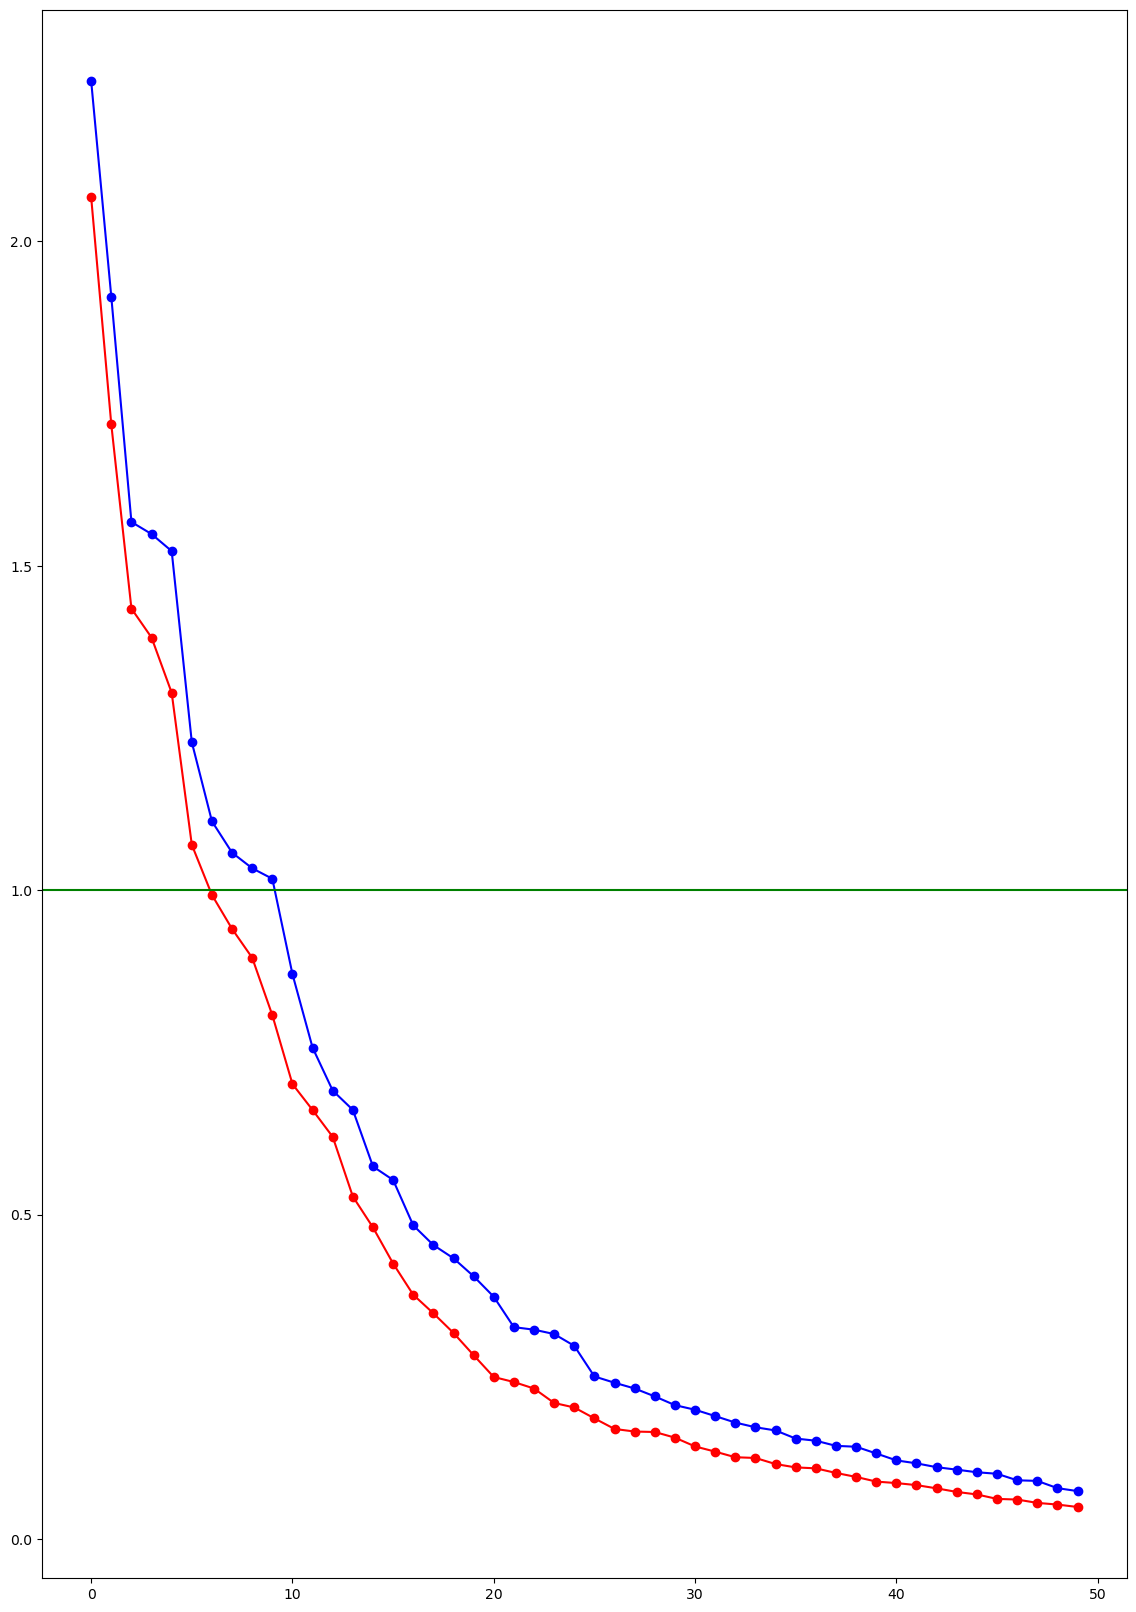

In [20]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [21]:
# ds_state = xr.open_dataset("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/inexact_gn_hessian_cg/state_GNHessCG_iter_5.nc")
# ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/prior_X.nc")

# dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
#                               "xx_q_geo": ds_state["xx_q_geo"].data.copy(),
#                               "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
#                               "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
#                               "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_n_glen_da_dummy2d_scalar": ds_state["xx_n_glen_da_dummy2d_scalar"].data[0].copy()}

# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old", None, ds_prior_X)

# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  4.418539621446117e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.4577987611457684e-15
eig (symmetrized) vs eigh:  1.1759210037024374e-15
First 10 eigenvalues: [2.20082149 1.86981596 1.50864792 1.47088549 1.46030581 1.13068256
 1.02277271 0.93122624 0.90517442 0.8082965 ]
Relative symmetry error of T:  4.58558064173736e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.8102477712456786e-15
eig (symmetrized) vs eigh:  1.67857022434592e-15
First 20 eigenvalues: [2.21411026 1.88892204 1.54678973 1.51564748 1.50729082 1.17710696
 1.039081   1.02647907 0.96376369 0.87809488 0.77481932 0.71865083
 0.63196788 0.56591821 0.52977203 0.47729462 0.45231907 0.41103973
 0.35731741 0.32072053]
Relative symmetry error of T:  4.668117707538622e-12
Complex parts check (imag > 2.

(array([2.25293707, 1.92182836, 1.57844124, 1.55823445, 1.53021757,
        1.24749598, 1.12603724, 1.07618337, 1.04678428, 1.03158074,
        0.88418139, 0.77211225, 0.70975279, 0.67298134, 0.59204663,
        0.58426628, 0.50252238, 0.4696831 , 0.46741303, 0.42851559,
        0.39666206, 0.3589295 , 0.34698646, 0.33588695, 0.31655299,
        0.28220589, 0.27171805, 0.25710059, 0.24580973, 0.23512043,
        0.23048959, 0.22969283, 0.22738104, 0.22037703, 0.19882263,
        0.19482496, 0.1871304 , 0.18361719, 0.17461542, 0.17077522,
        0.169172  , 0.16372607, 0.15374957, 0.15031532, 0.14705644,
        0.14352782, 0.14104094, 0.13852017, 0.13218903, 0.1318994 ,
        0.12200046, 0.11682057, 0.11434442, 0.11399497, 0.10619442,
        0.103141  , 0.09538349, 0.0950025 , 0.08887785, 0.08759929,
        0.08736351, 0.08601367, 0.08411386, 0.078881  , 0.07436727,
        0.06857355, 0.06834307, 0.06757639, 0.06734969, 0.06665293,
        0.06428247, 0.06396382, 0.06041163, 0.05

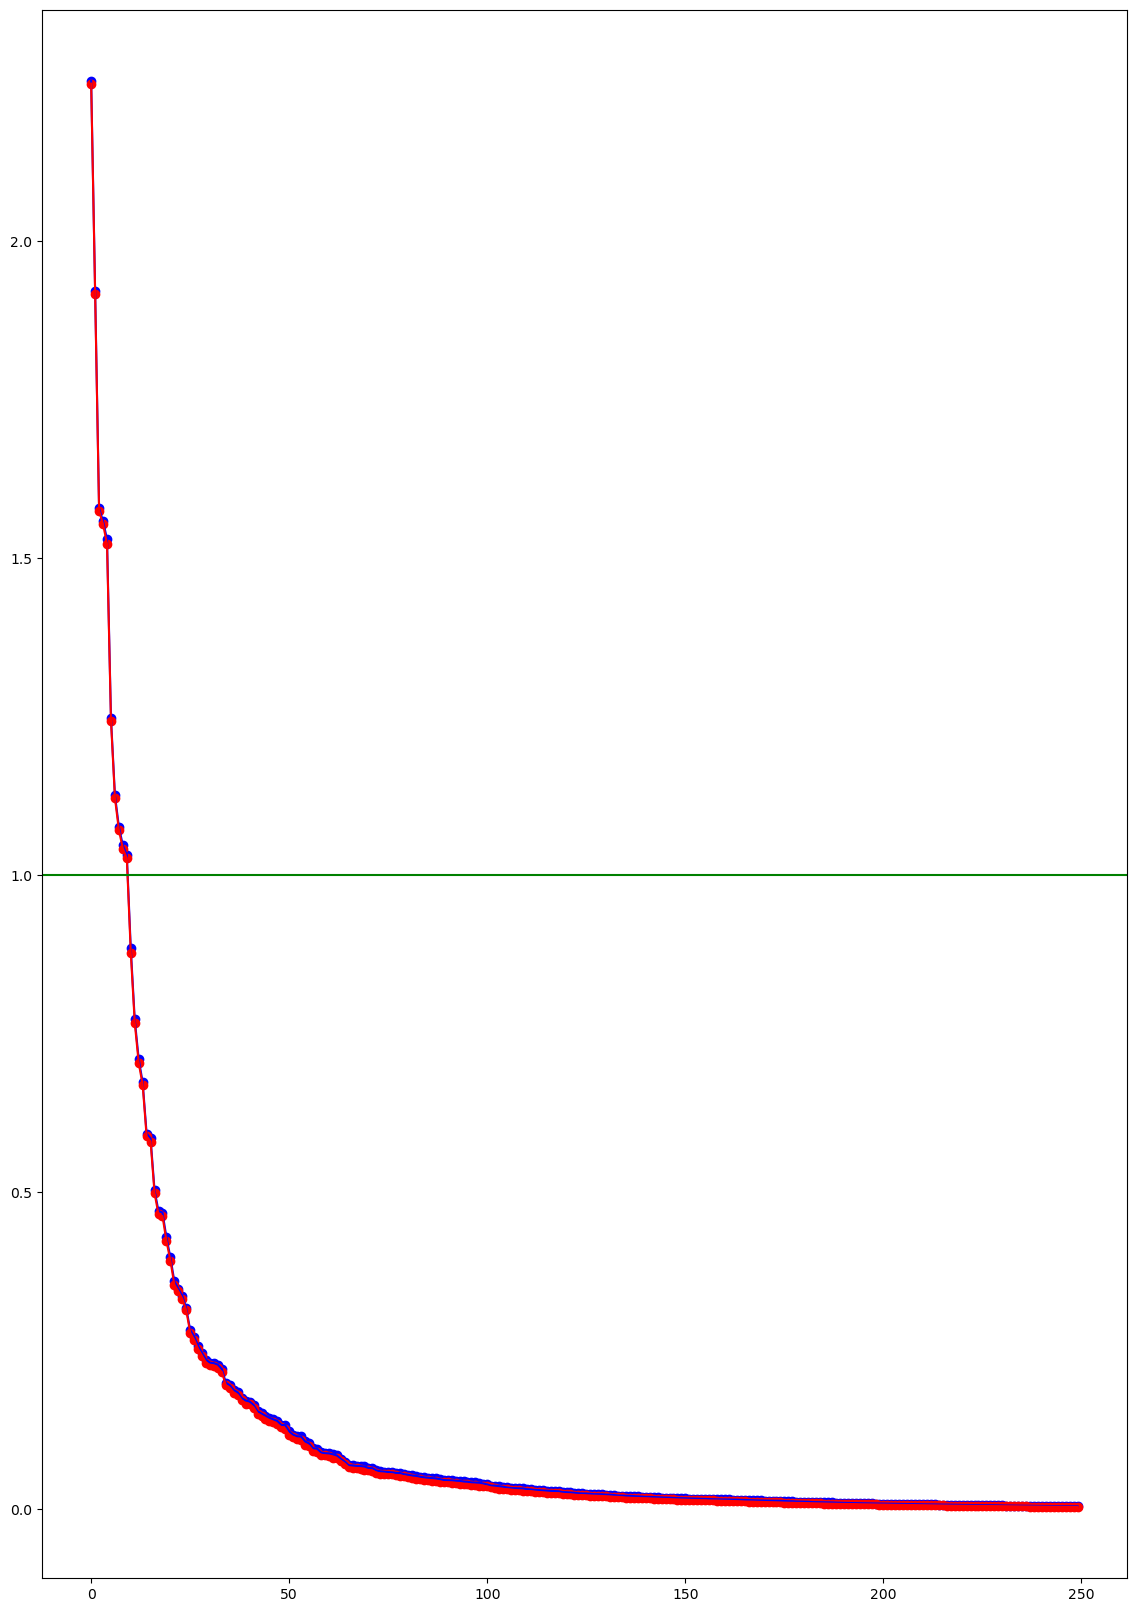

In [22]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [23]:
# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp = DA.forward_uq_propagation(U_misfit_dp, Lambda_misfit_dp)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)

# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp, sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(2.838320055540861e+17, 1.7174105425083085e+17, 0.39492005520813467)

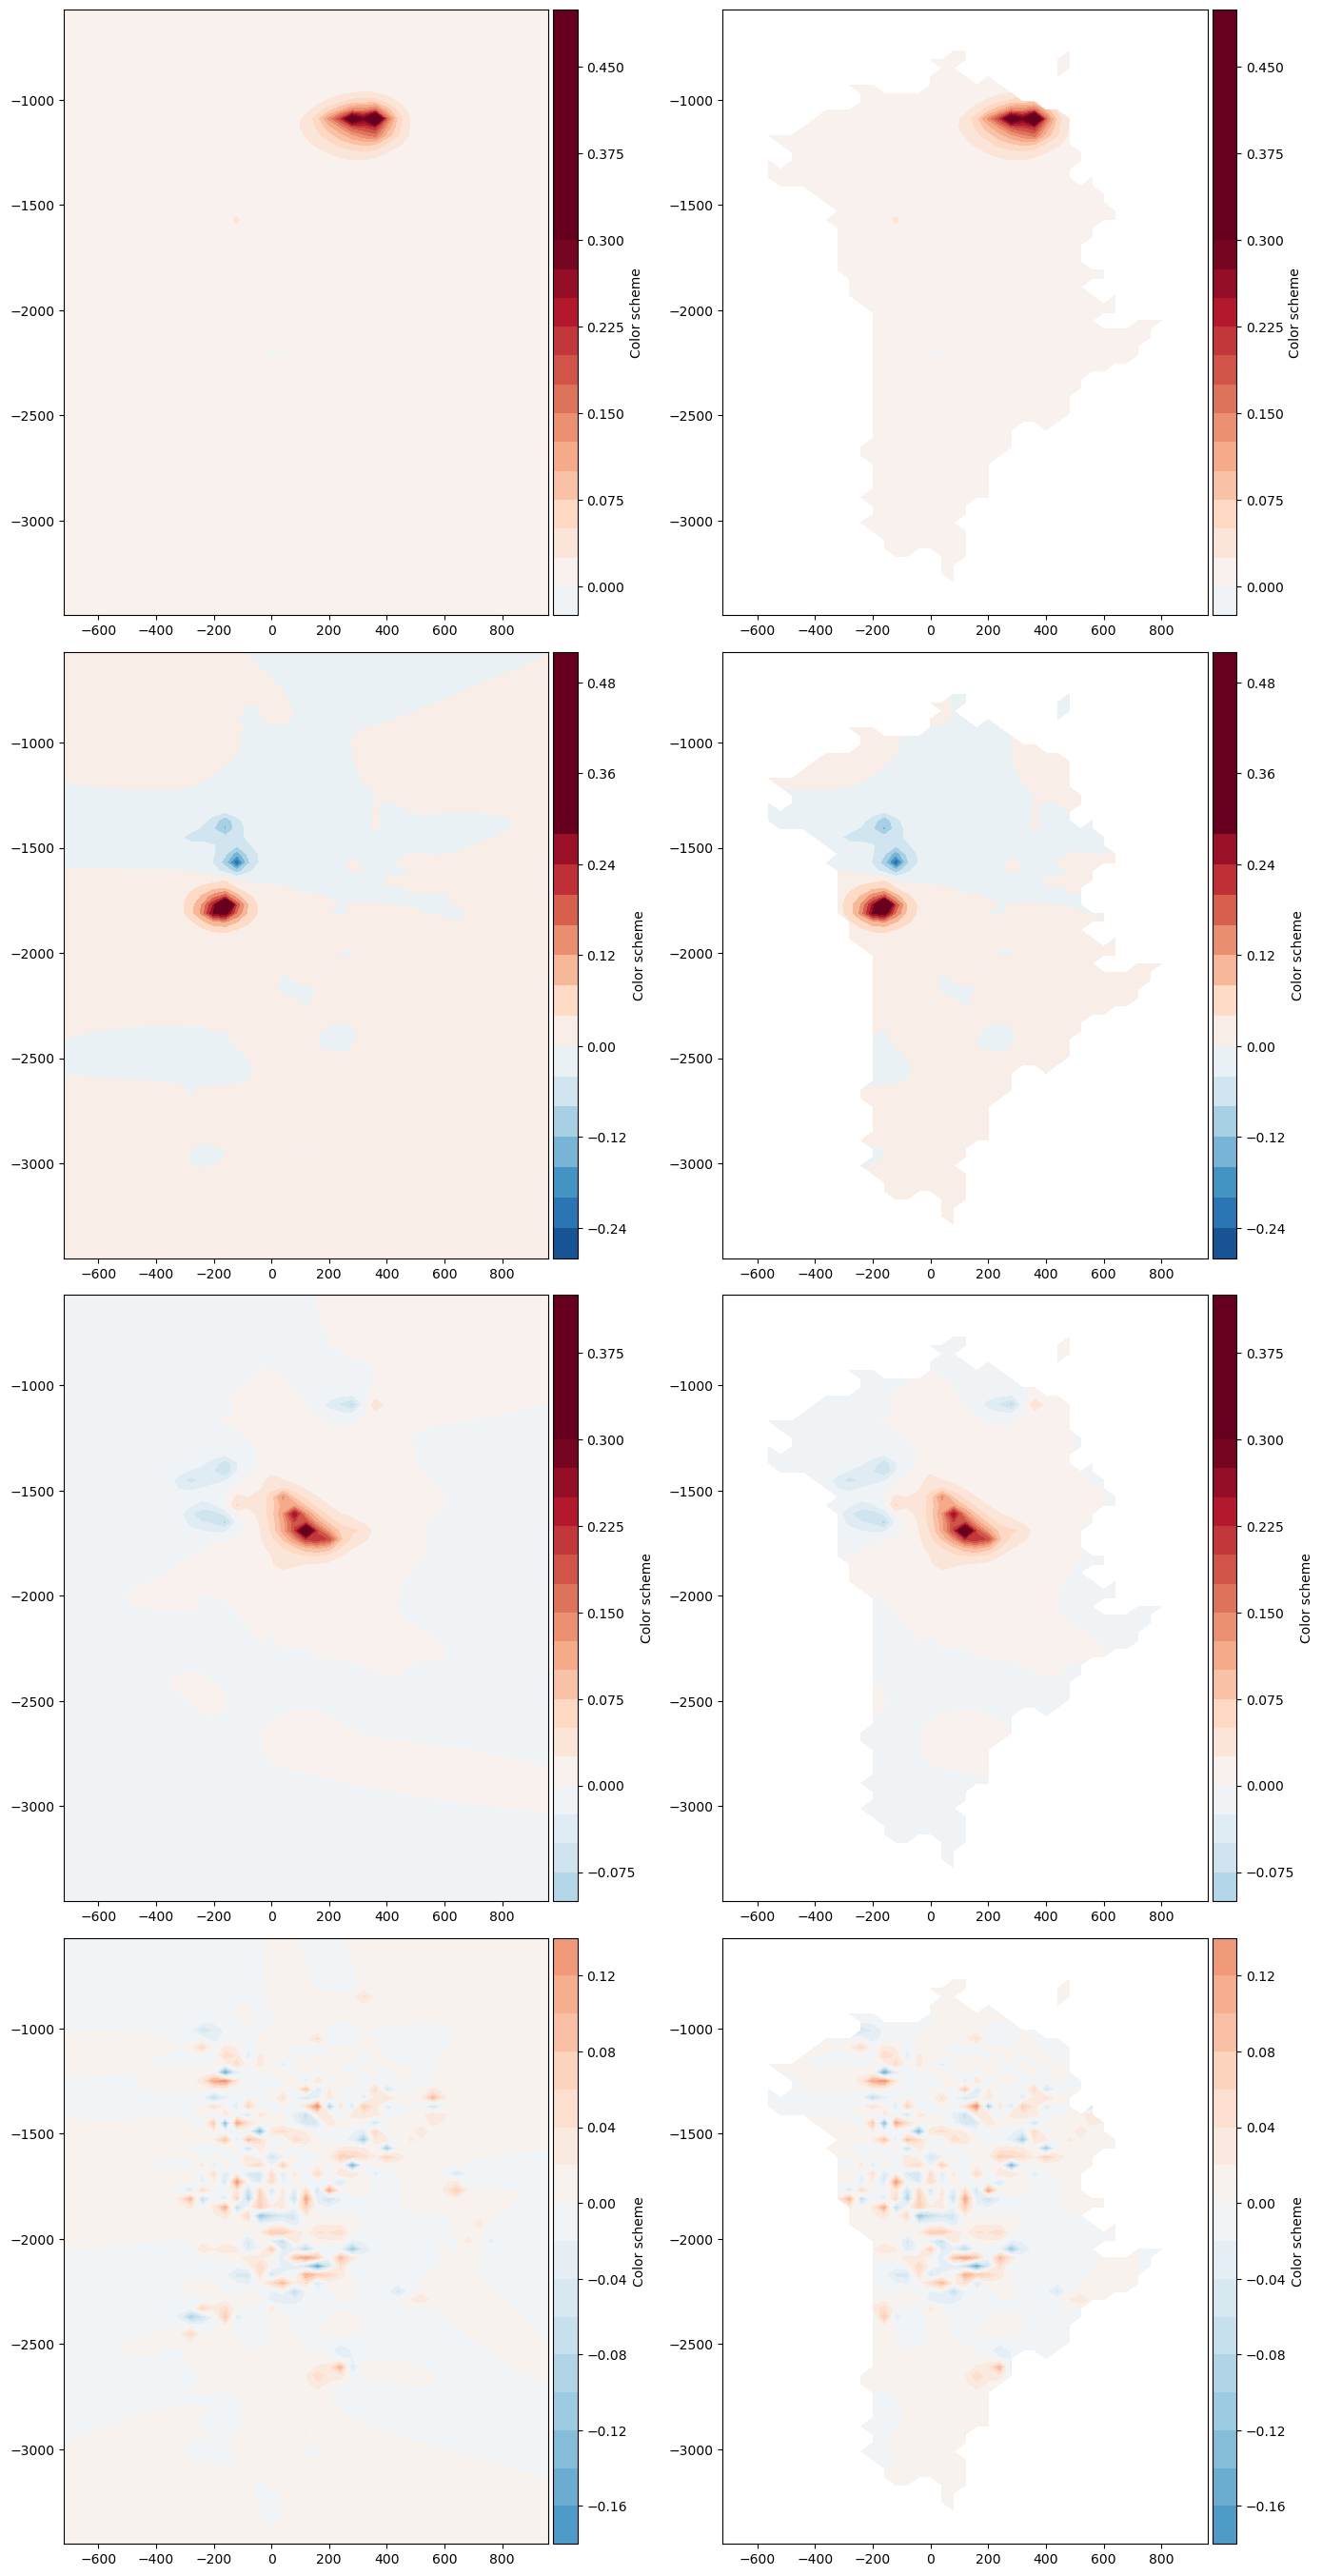

In [24]:
U_misfit_dp_reshaped = np.reshape(U_misfit_dp[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

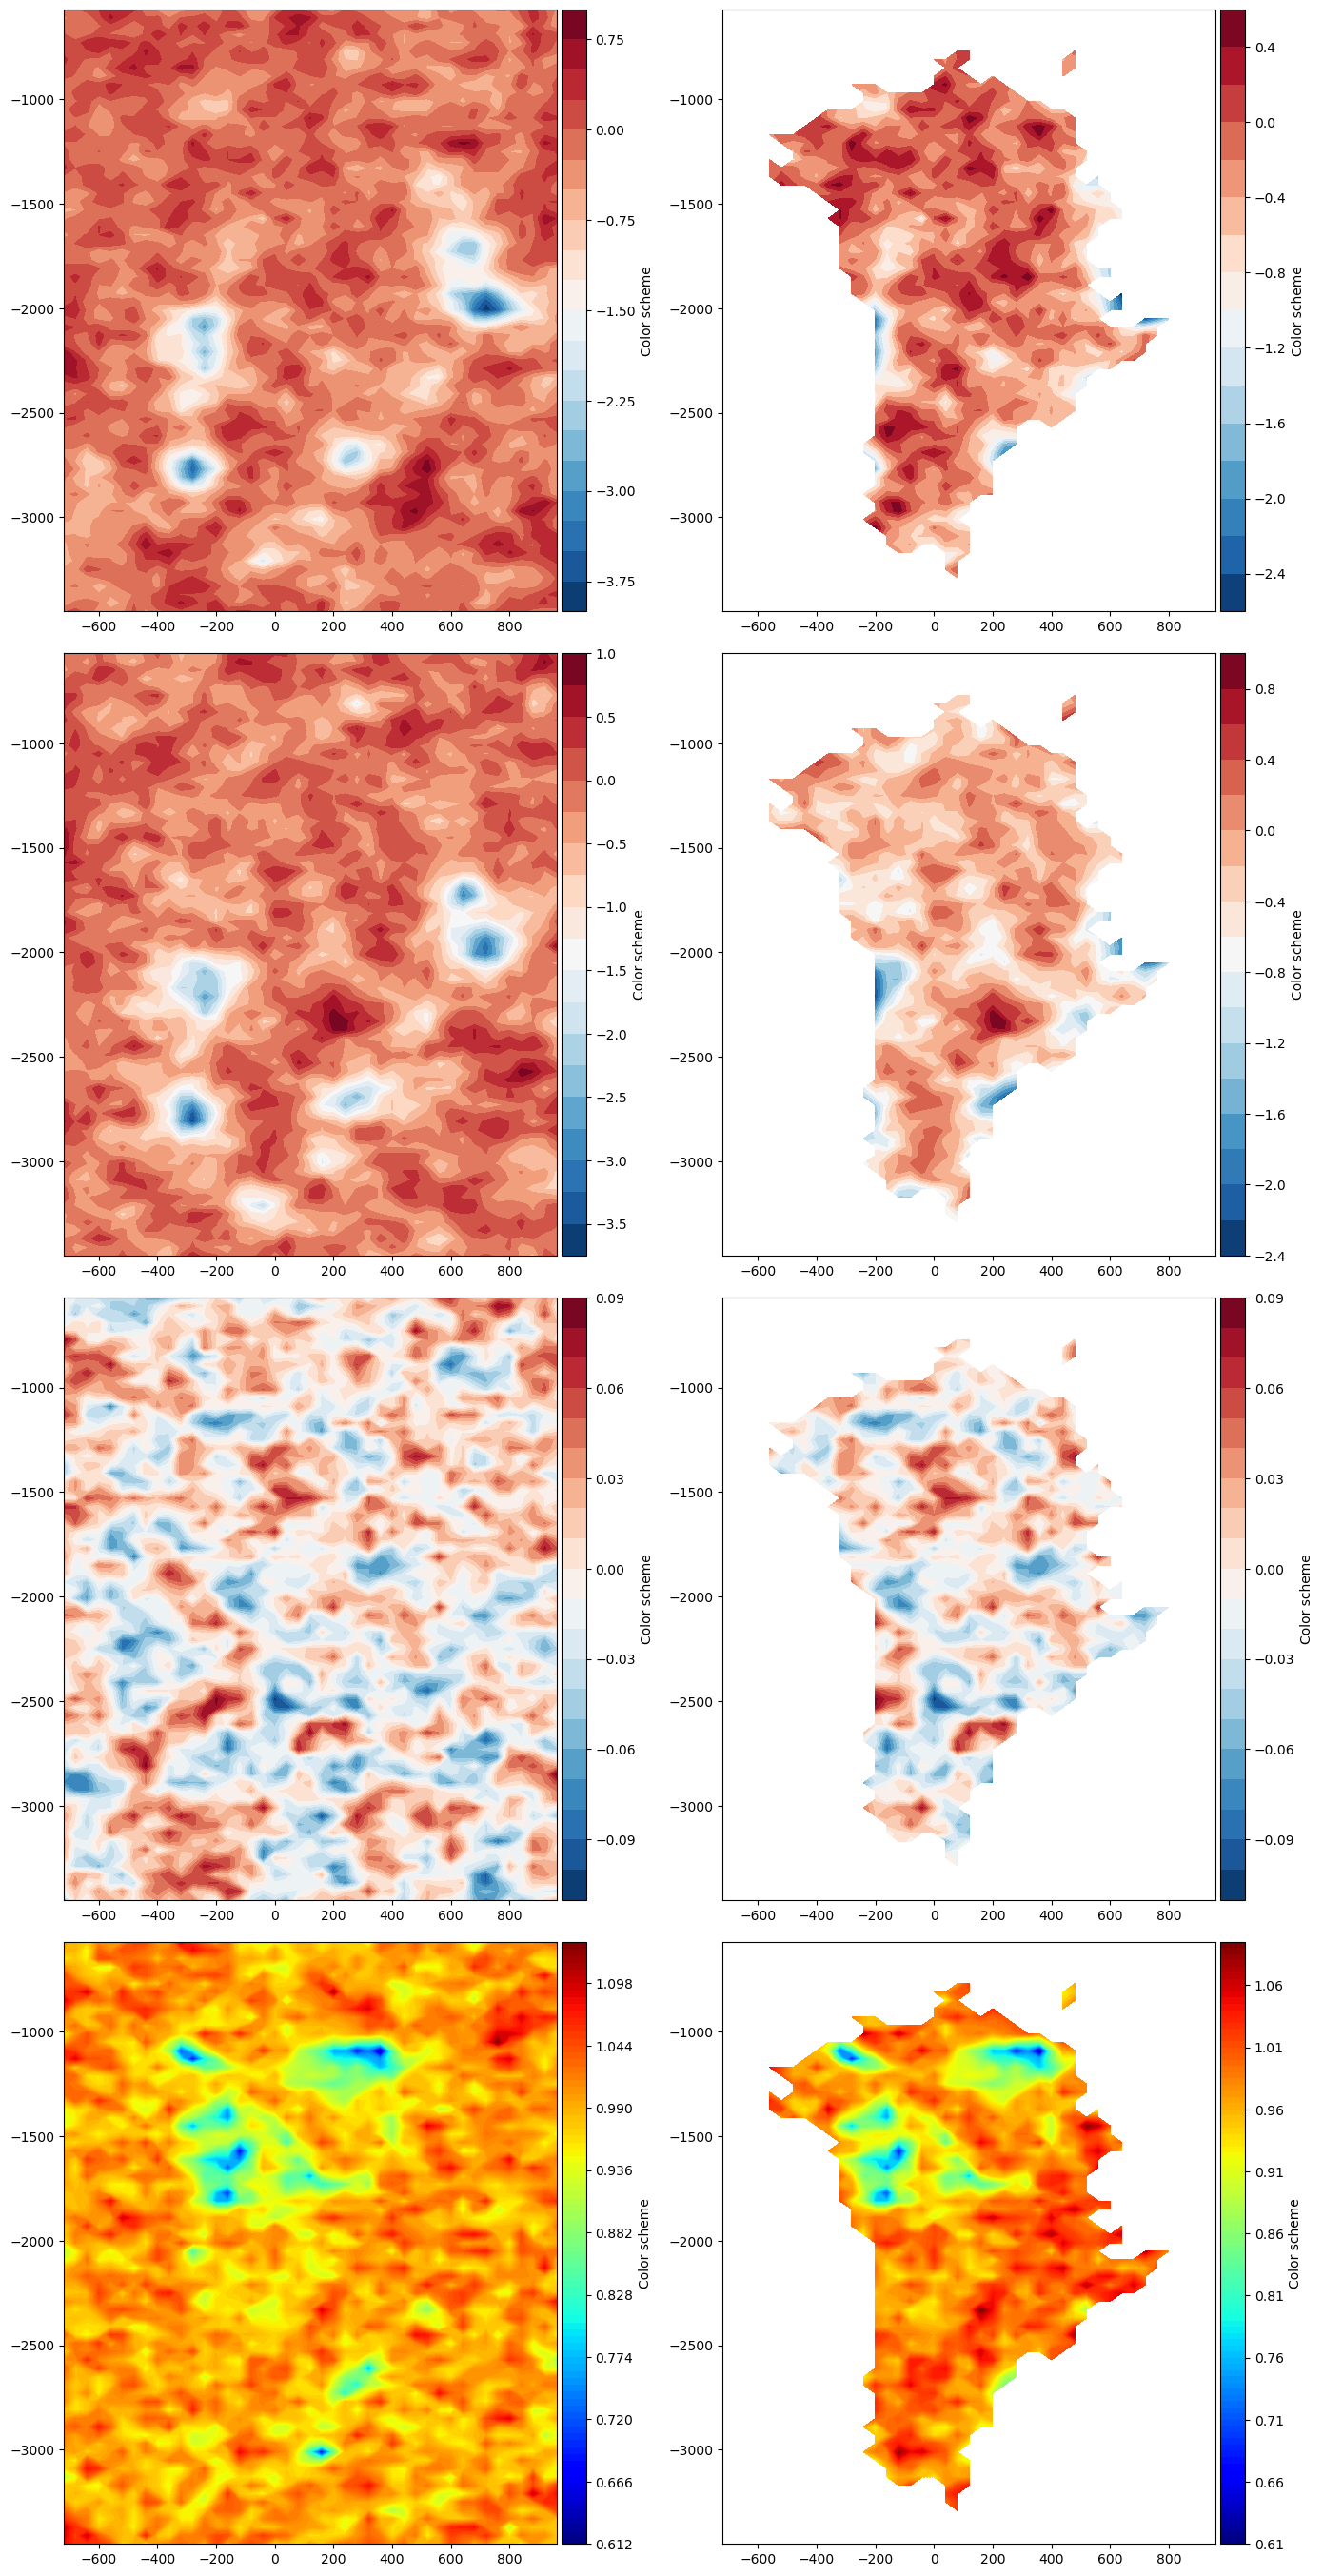

In [25]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit_dp, Lambda_misfit_dp)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

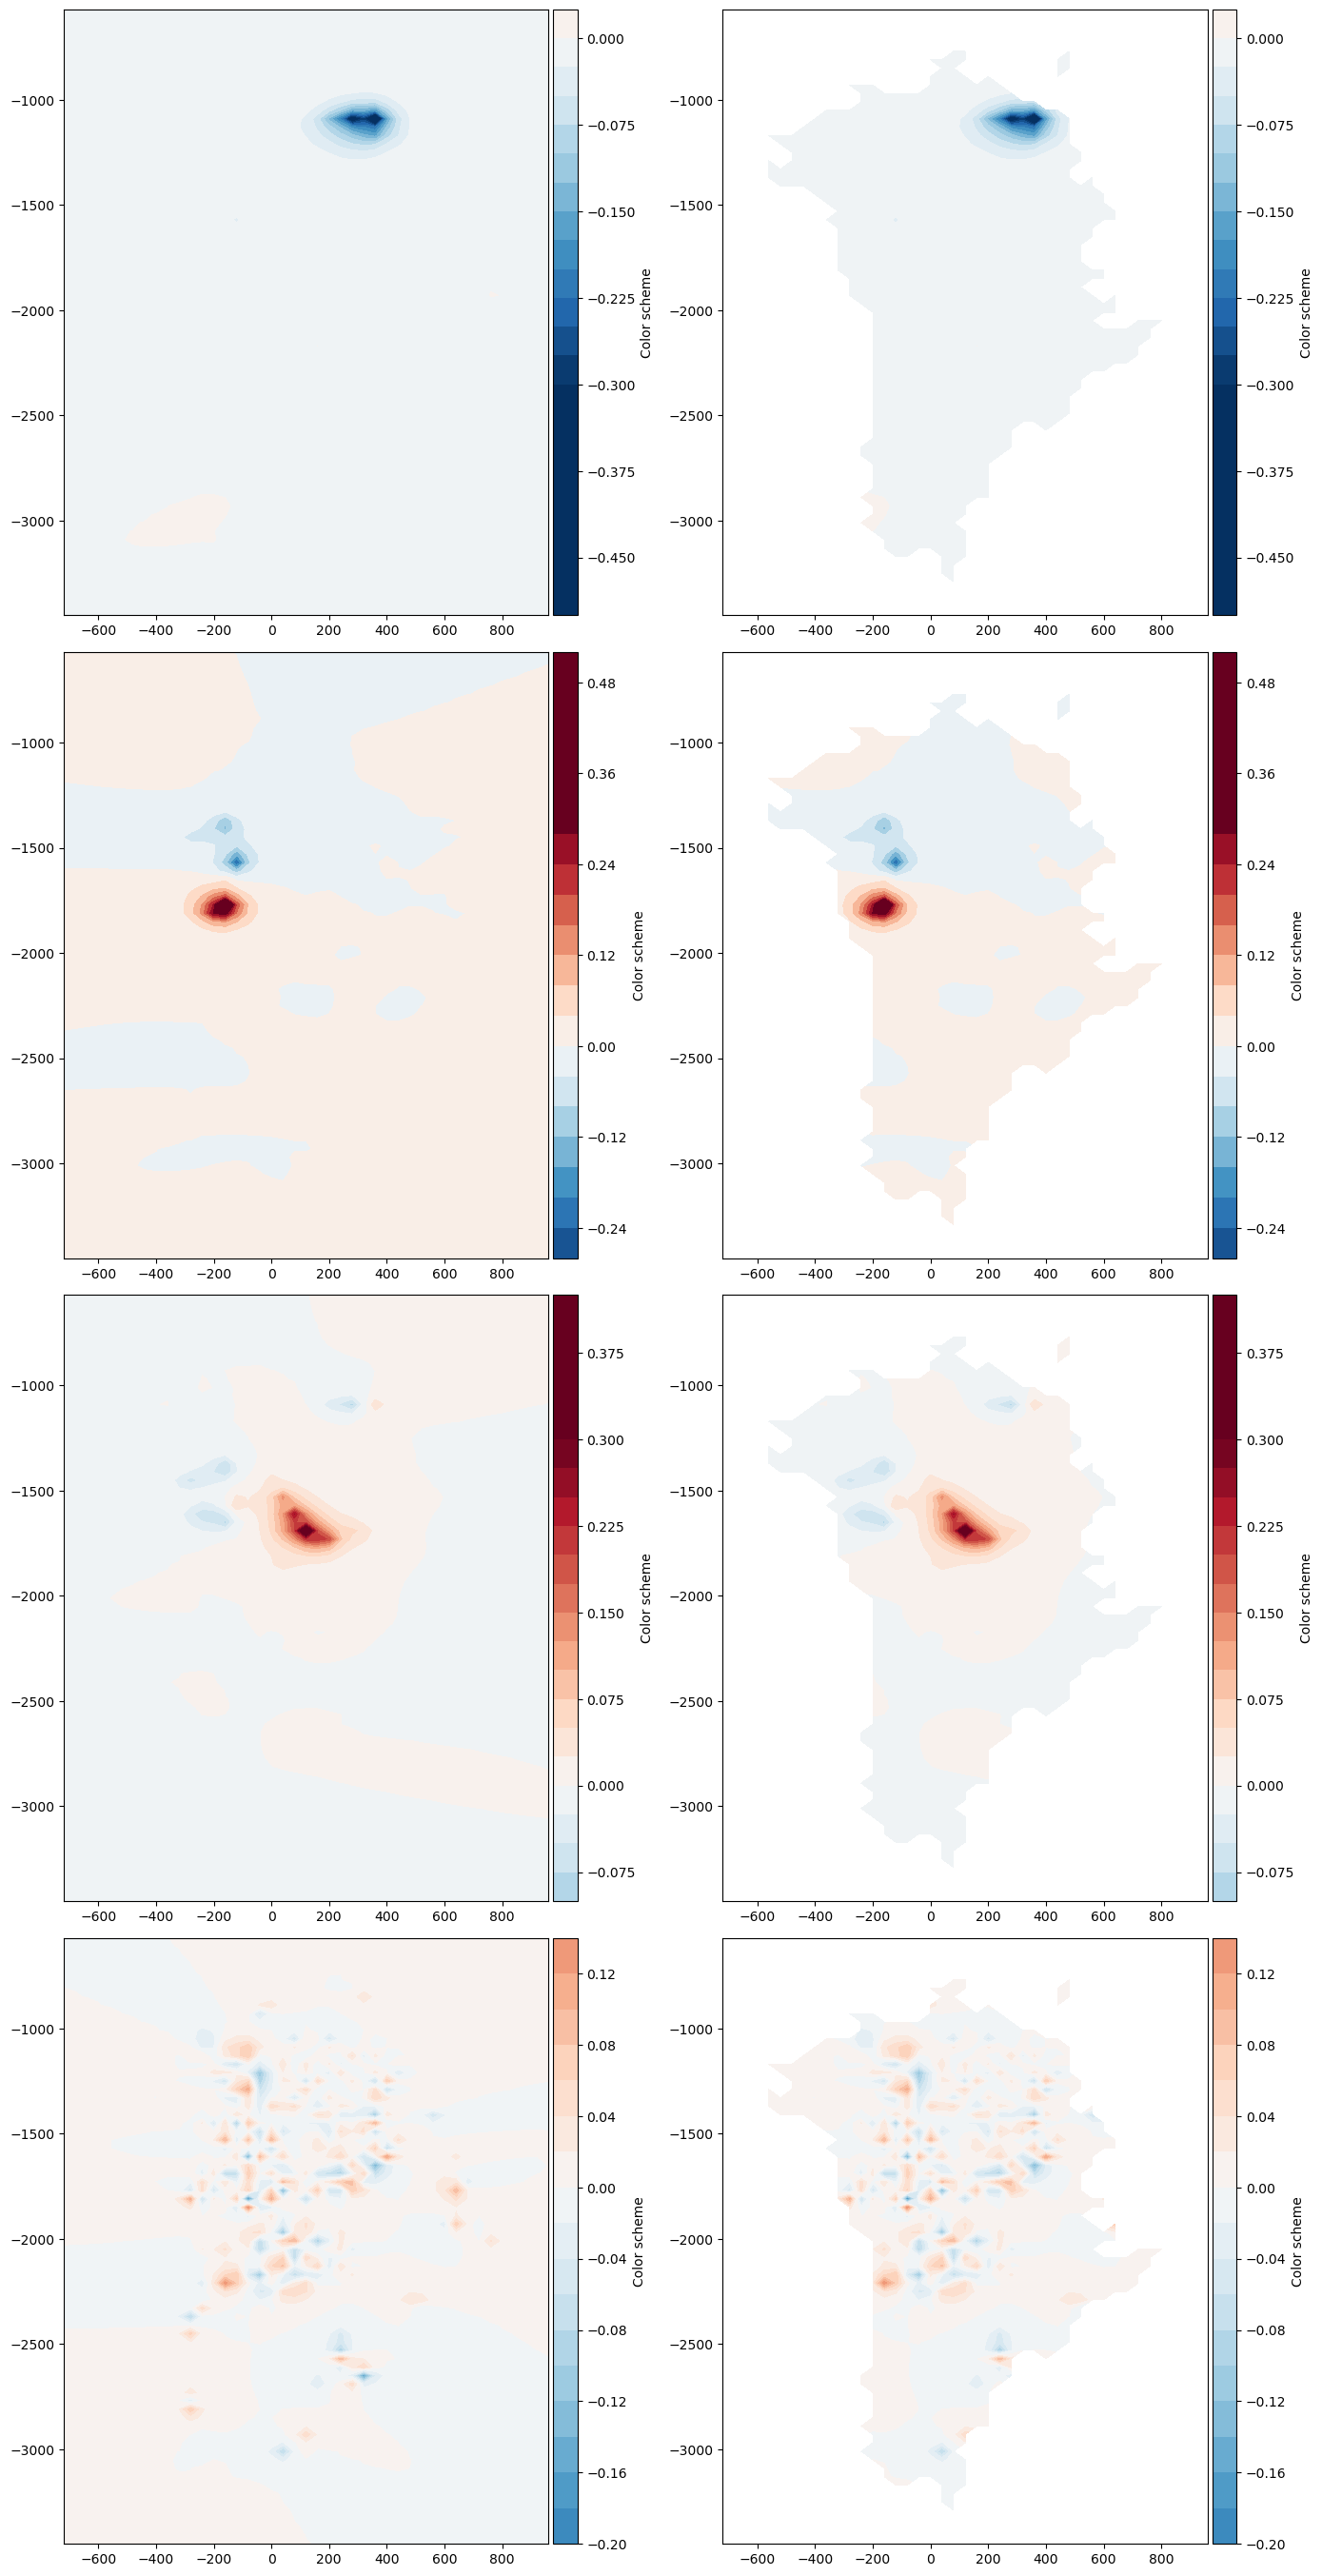

In [26]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

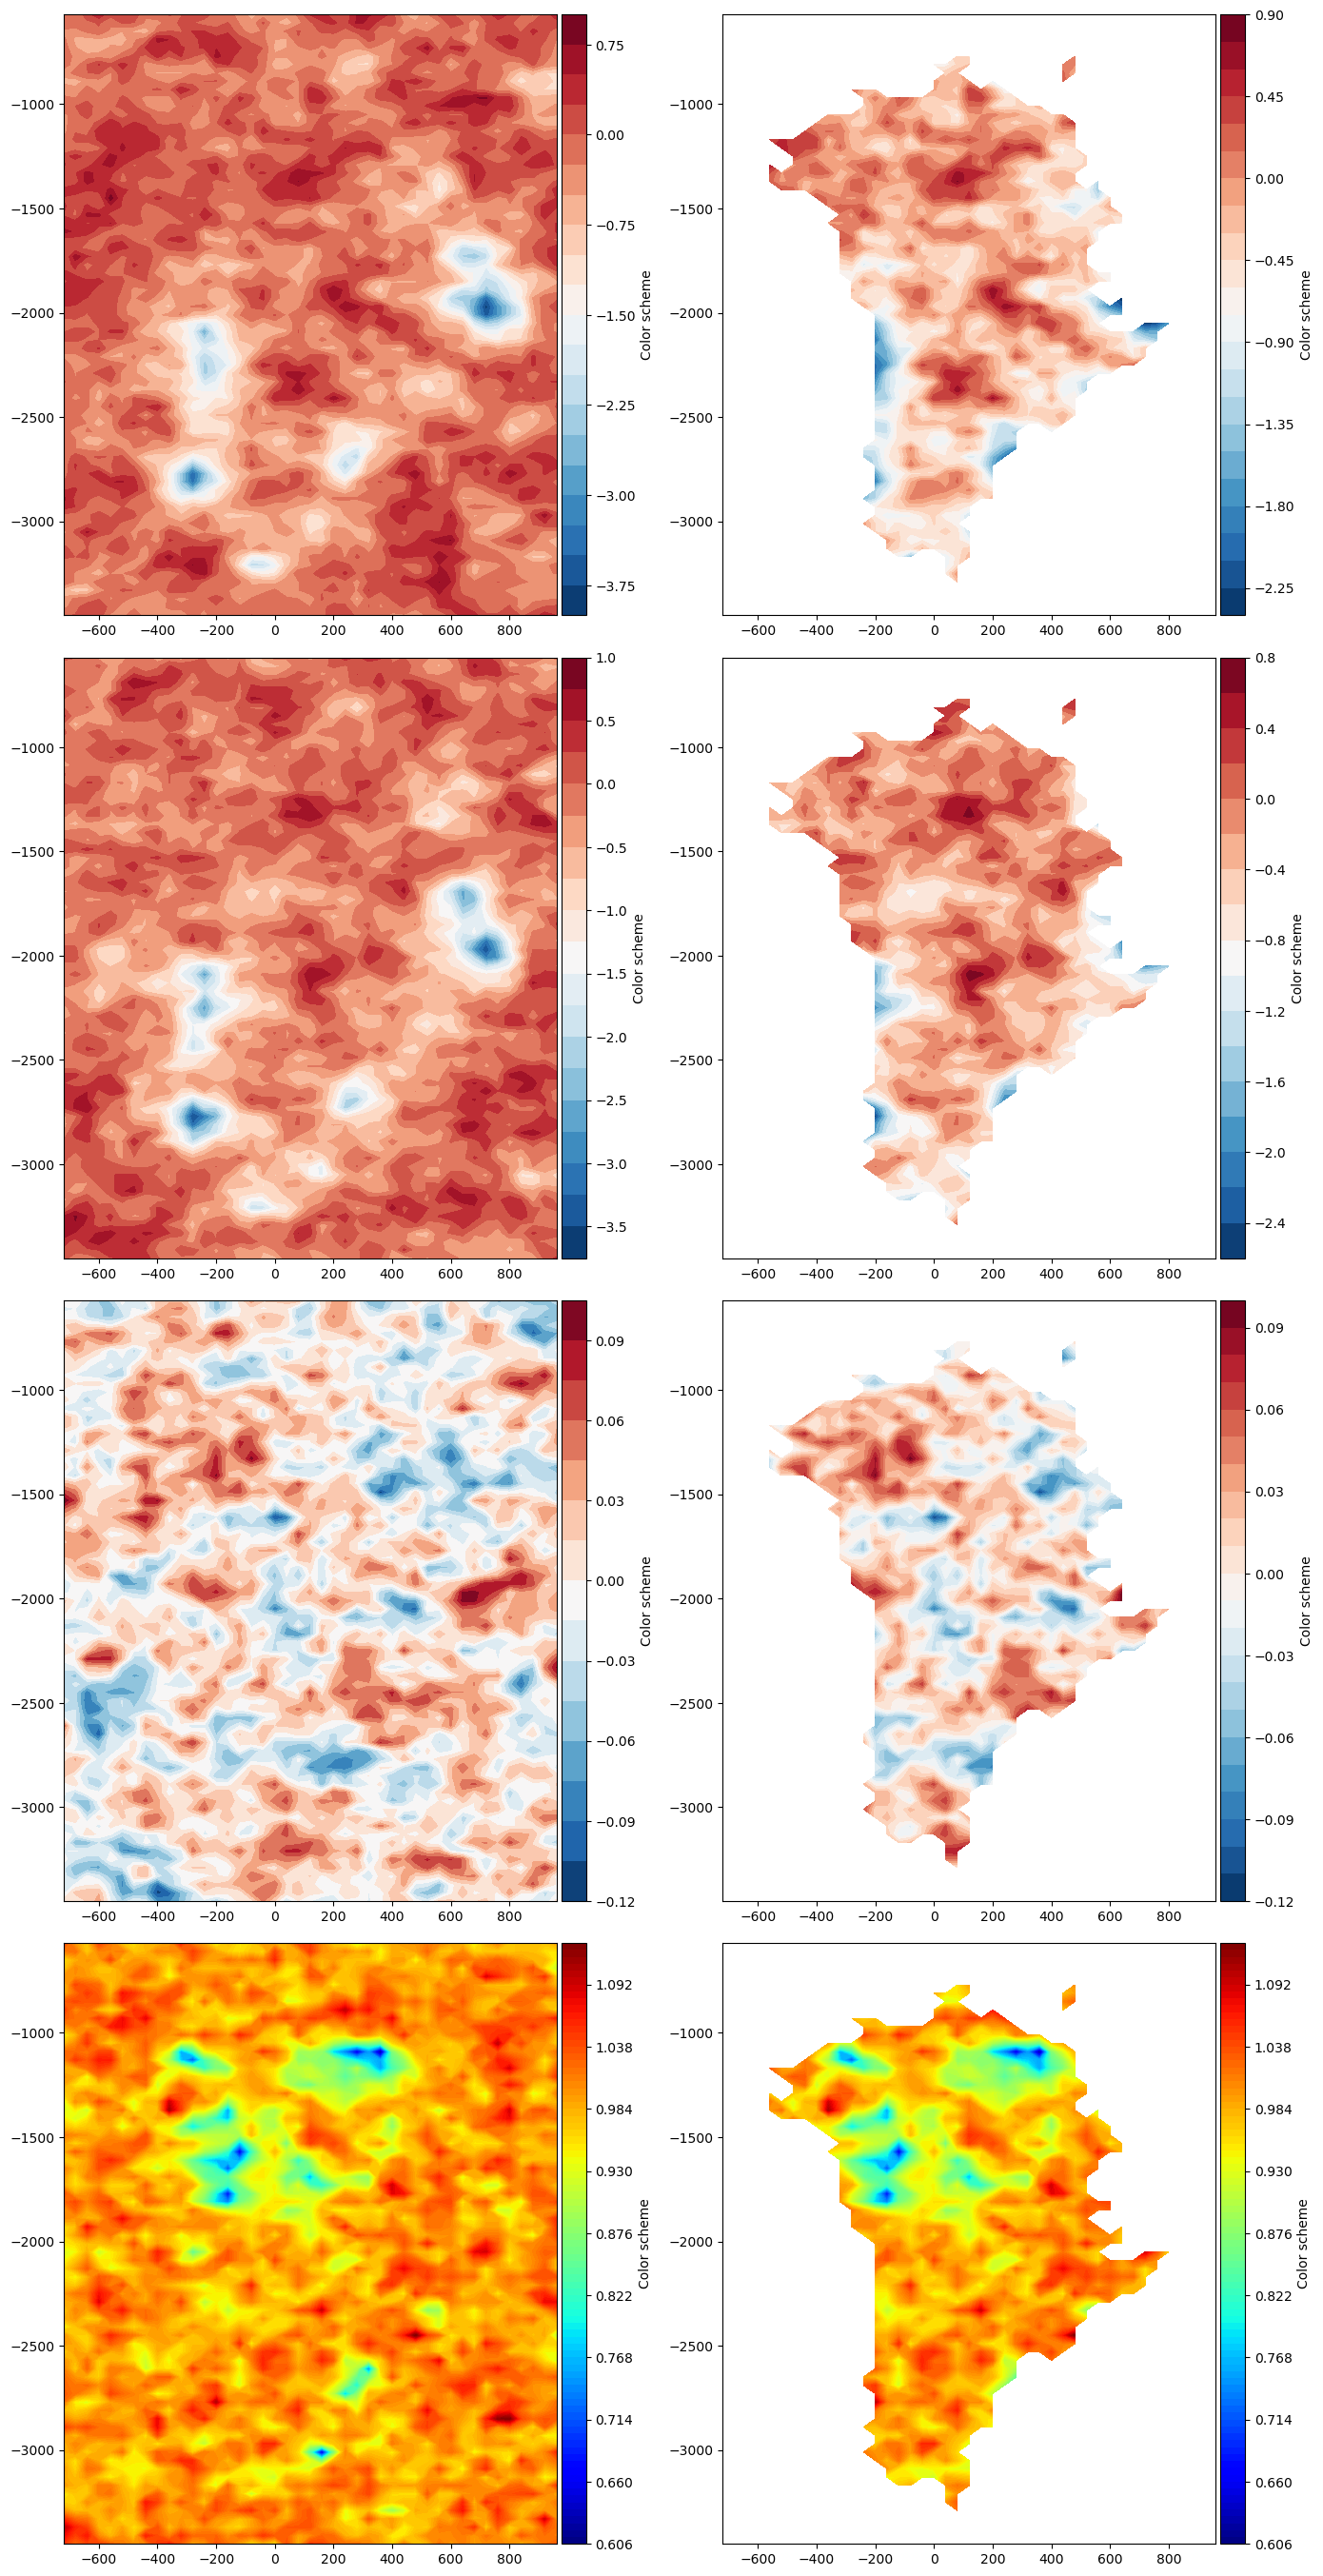

In [27]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit_sa, Lambda_misfit_sa)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [28]:
ds_std_samples_prior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.2897 0.2972 ... 0.2981
    xx_q_geod                       (y, x) float64 25kB 0.2885 0.2926 ... 0.2877
    xx_p_weertd                     (scalar) float64 8B 0.01035
    xx_q_weertd                     (scalar) float64 8B 0.01003
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.009652
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.009873
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.009701

In [29]:
ds_std_samples_posterior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.3041 0.3036 ... 0.2955
    xx_q_geod                       (y, x) float64 25kB 0.2929 0.2966 ... 0.2934
    xx_p_weertd                     (scalar) float64 8B 0.009654
    xx_q_weertd                     (scalar) float64 8B 0.009769
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.006675
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.009084
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.00733

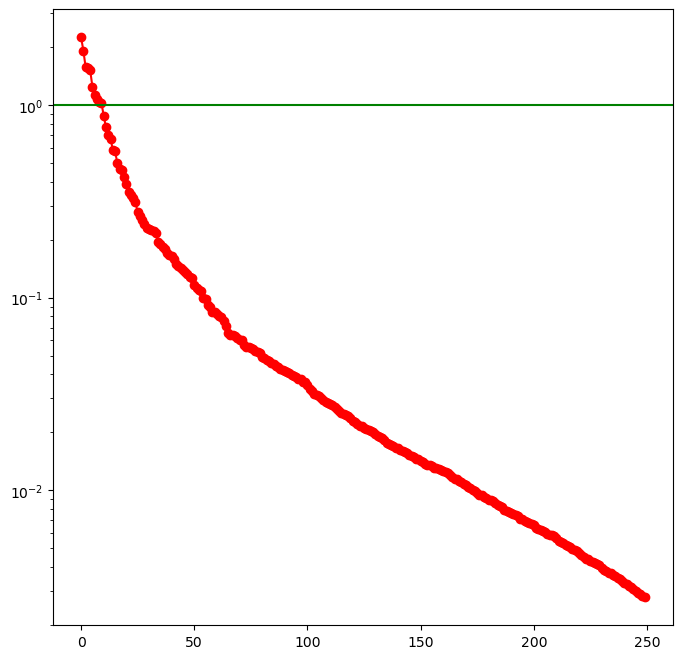

In [30]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color="red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color="red")

plt.axhline(1, color="green")

plt.yscale("log")

In [31]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta_old", None, ds_prior_X)

# DA.l_bfgs(5, 3)